####  We are going to predict whether someone would survive Titanic Disaster or not! <br>Using the following Random Forest  and compare which is more accurate and build on it.<br><br>  1.Decision Trees<br>2.Support Vector Machine



In [87]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import pydot

import matplotlib.pyplot as plt
import seaborn as sns

import warnings; warnings.simplefilter('ignore')




#### Data Exploration

In [88]:
titanic_train=pd.read_csv("data/titanic/train.csv")
titanic_test=pd.read_csv("data/titanic/test.csv")

In [89]:
titanic_train.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [90]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [91]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


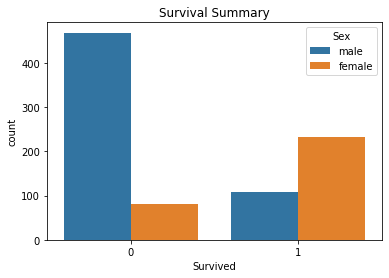

In [92]:
plt.title("Survival Summary") 
sns.countplot(x='Survived',data=titanic_train,hue='Sex')

generally the survival rate for men was literaly low compared to women.This is a fact since the evacuation rule was 
women and children first
Most Likely the male who survived might be children 

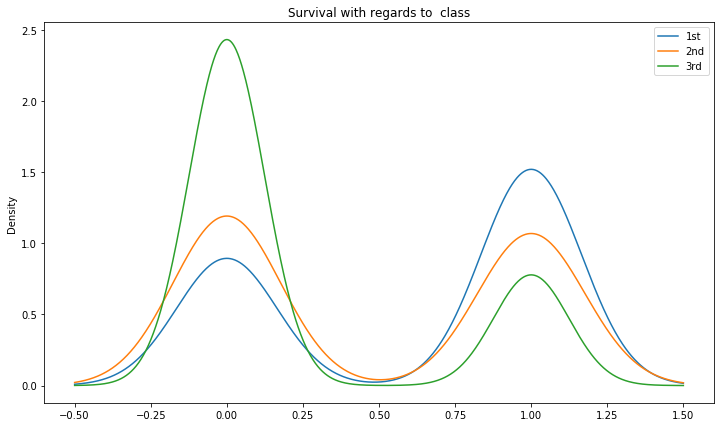

In [93]:
fig=plt.figure(figsize=(12,7))
for x in 1,2,3:
    
    plt.title("Survival with regards to  class")
    titanic_train.Survived[titanic_train.Pclass==x].plot(kind="kde")
    plt.legend(("1st","2nd","3rd"))
plt.show()

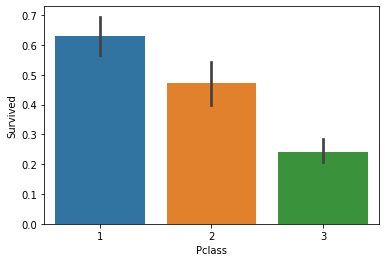

In [94]:
sns.barplot(x='Pclass', y='Survived', data=titanic_train)

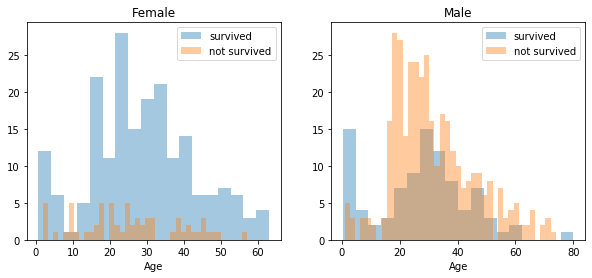

In [95]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = titanic_train[titanic_train['Sex']=='female']
men = titanic_train[titanic_train['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

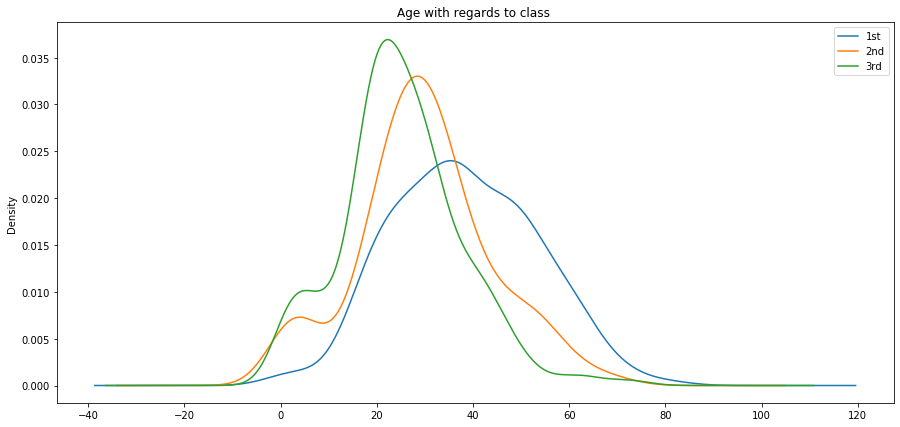

In [96]:
fig=plt.figure(figsize=(15,7))
for x in 1,2,3:
    
    plt.title("Age with regards to class ")
    titanic_train.Age[titanic_train.Pclass==x].plot(kind="kde")
    plt.legend(("1st","2nd","3rd"))
plt.show()


#### Data Cleaning

In [97]:
titanic_train.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [98]:
def clean_data(data):
    data["Age"]=data["Age"].fillna(data["Age"].dropna().median())
    data["Fare"]=data["Fare"].fillna(data["Fare"].dropna().median())
    data['Fare'] = data['Fare'].astype(int)
    data.loc[data["Sex"]=="male","Sex"]=0
    data.loc[data["Sex"]=="female","Sex"]=1
    
    data["Embarked"]=data["Embarked"].fillna("S")
    
    data.loc[data["Embarked"]=="S","Embarked"]=0
    data.loc[data["Embarked"]=="C","Embarked"]=1
    data.loc[data["Embarked"]=="Q","Embarked"]=2
    
    

In [99]:
clean_data(titanic_train)
clean_data(titanic_test)

what we did on this data was<br>
1.Fill all the missing values of Age and Fare with median<br>
2.convert Gender into numerical values which machine learning can work on


#### Building Machine Learning Models

In [100]:
#RANDOM TREE ALGORITHM
features=["Sex","Age","Fare","Pclass","Parch","SibSp","Embarked"]
y_train=titanic_train["Survived"]
X_train=titanic_train[features]
X_test=titanic_test[features]

features are the crucial data entry which we shall used to predit.Next is to check the weight of the features.

In [101]:
random_forest=RandomForestRegressor(n_estimators=250,random_state=1)
random_forest.fit(X_train,y_train)
random_prediction=random_forest.predict(X_test)
random_tree_accuracy=round(random_forest.score(X_train,y_train)*100, 2)


In [102]:
#the accuracy of the model
random_forest.score(X_train,y_train)

0.8465035054773609

#### Fine Tuning Our Forest to improve on the 84% accuracy

In [103]:
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
    
}

In [104]:
cv = GridSearchCV(random_forest,parameters,cv=5)
cv.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=250, n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 4, 8, 16, 32, None],

In [105]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [106]:
cv.score(X_test,random_prediction)

0.6446979938040832

In [107]:

display(cv)

Best parameters are: {'max_depth': 4, 'n_estimators': 250}


0.364 + or -0.064 for the {'max_depth': 2, 'n_estimators': 5}
0.368 + or -0.069 for the {'max_depth': 2, 'n_estimators': 10}
0.376 + or -0.064 for the {'max_depth': 2, 'n_estimators': 50}
0.375 + or -0.065 for the {'max_depth': 2, 'n_estimators': 100}
0.375 + or -0.063 for the {'max_depth': 2, 'n_estimators': 250}
0.416 + or -0.098 for the {'max_depth': 4, 'n_estimators': 5}
0.423 + or -0.097 for the {'max_depth': 4, 'n_estimators': 10}
0.435 + or -0.093 for the {'max_depth': 4, 'n_estimators': 50}
0.435 + or -0.089 for the {'max_depth': 4, 'n_estimators': 100}
0.437 + or -0.089 for the {'max_depth': 4, 'n_estimators': 250}
0.412 + or -0.092 for the {'max_depth': 8, 'n_estimators': 5}
0.416 + or -0.083 for the {'max_depth': 8, 'n_estimators': 10}
0.424 + or -0.09 for the {'max_depth': 8, 'n_estimators': 50}
0.431 + or -0.085 for the {'max_depth': 8, 'n_estimators': 100}
0.433 + or -0.085 for the {'max_depth': 8, 'n_estimators

In [108]:
random_forest=RandomForestRegressor(n_estimators=1000,random_state=1)
random_forest.fit(X_train,y_train)
random_prediction=random_forest.predict(X_test)
random_tree_accuracy=round(random_forest.score(X_train,y_train)*100, 2)

In [109]:
final_score=random_forest.score(X_test,random_prediction)
final_score

1.0

In [110]:
rates=cv.predict(X_test)

#### FOREST VISUAL

In [111]:
tree=random_forest.estimators_[4]
export_graphviz(tree, out_file = 'tree.dot', feature_names = features, rounded = True, precision = 1)
(graph,)= pydot.graph_from_dot_file('tree.dot')
graph.write_png('data/tree.png')

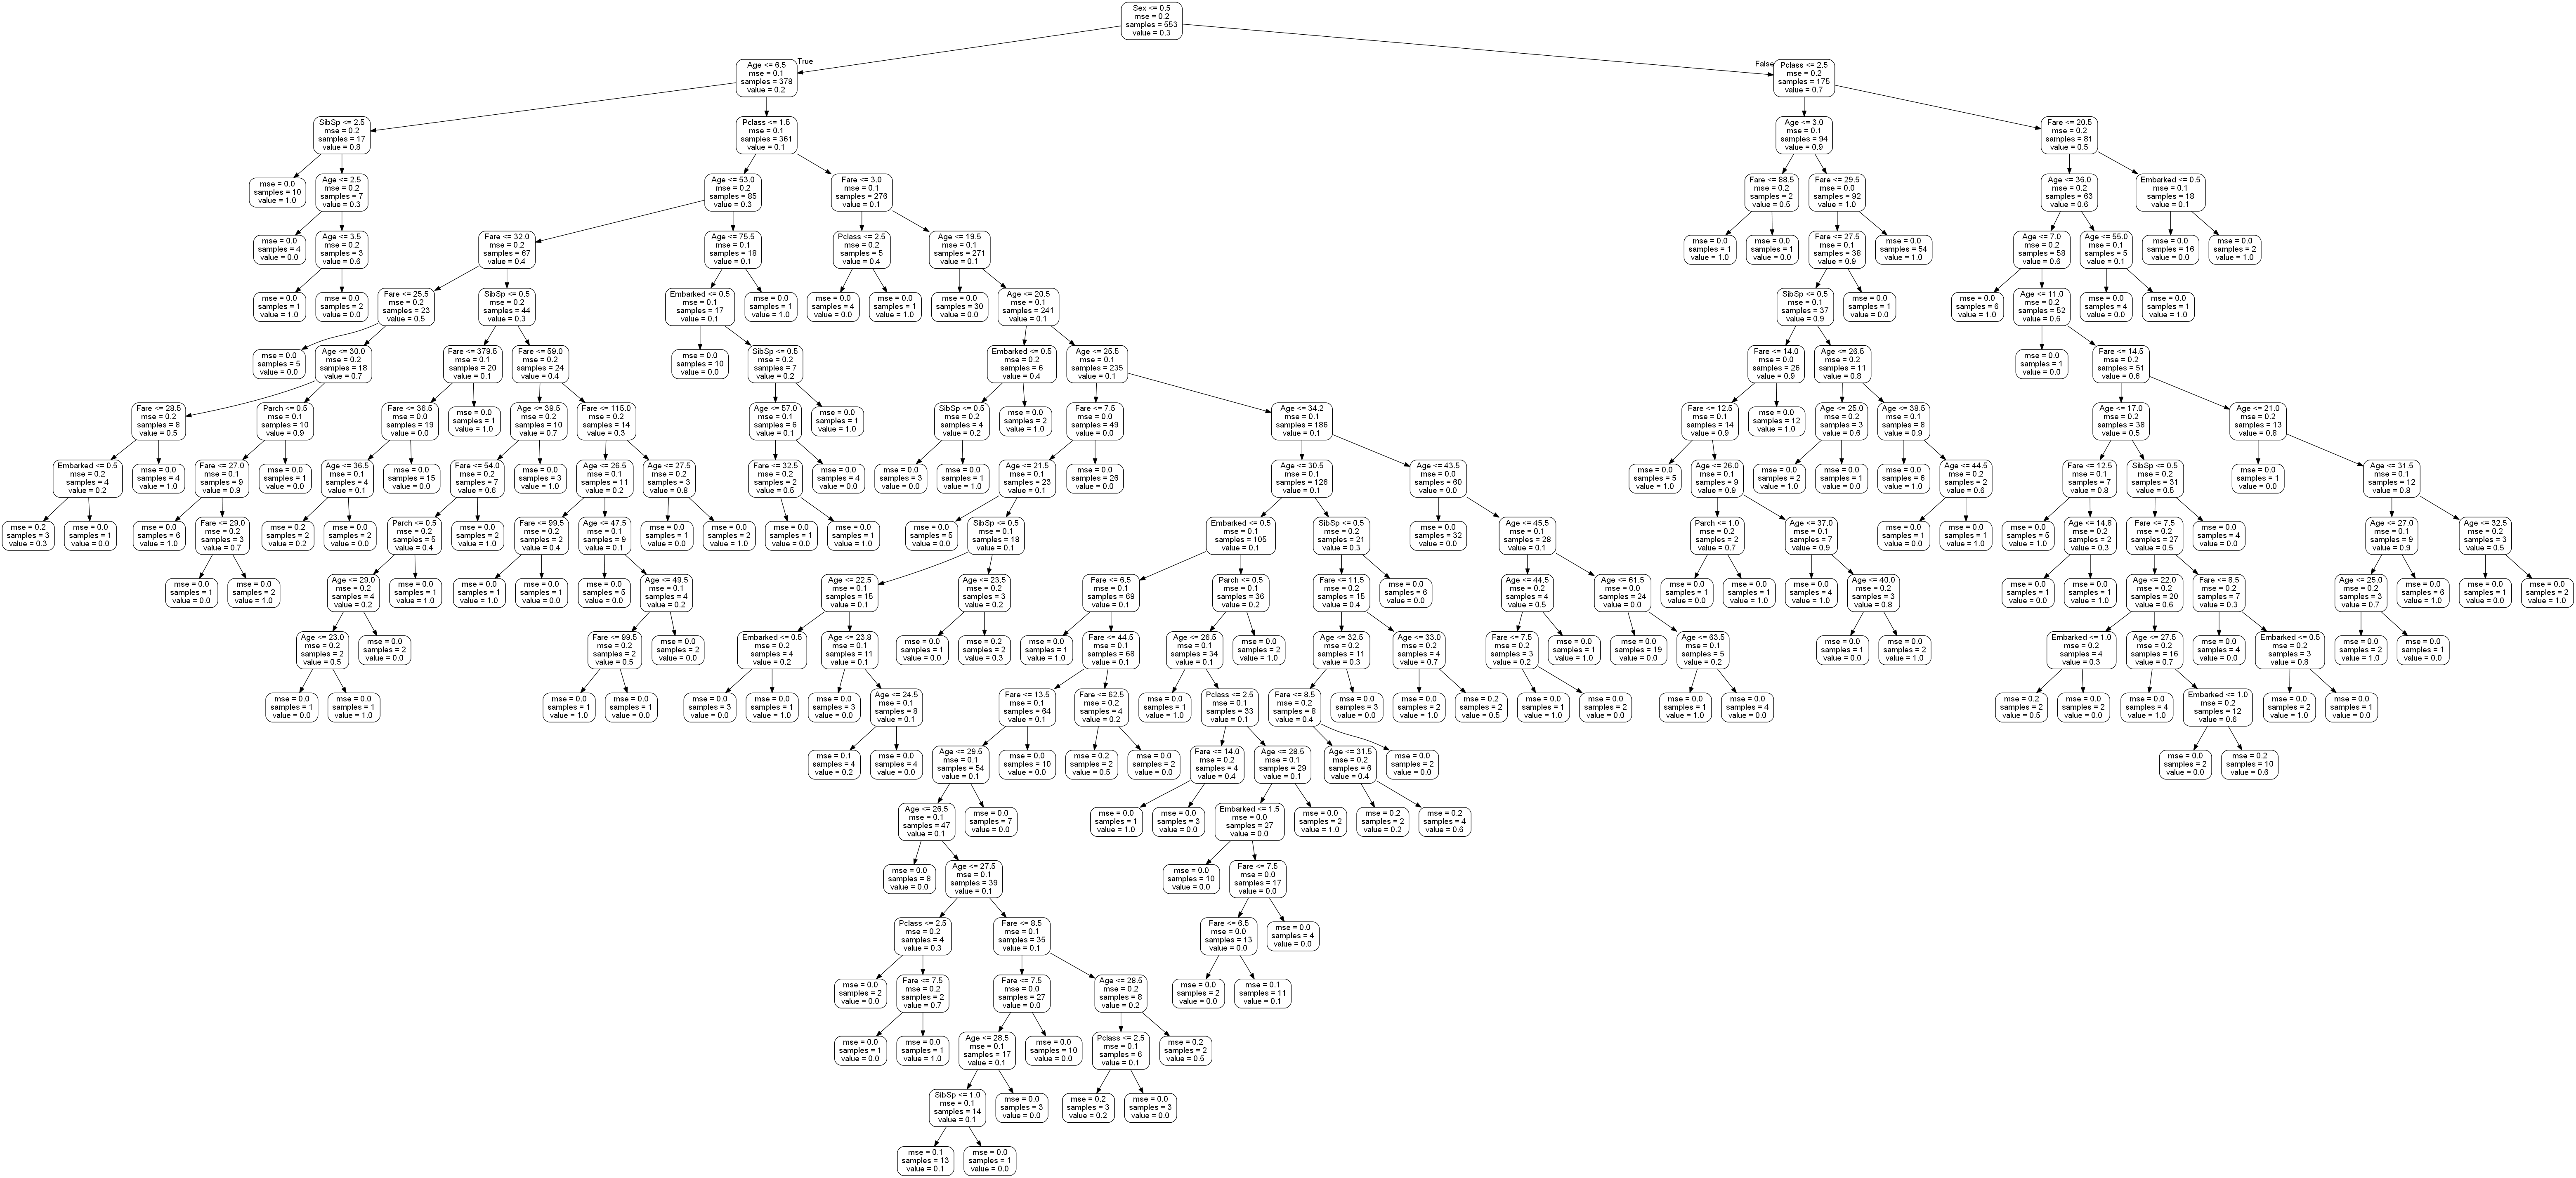

In [112]:
from IPython.display import Image 
Image("data/tree.png")

### other ml algorithms in place

In [113]:
#DECISION TREES
decision_tree=DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)  
tree_prediction = decision_tree.predict(X_test)  
tree_accuracy = round(decision_tree.score(X_train, y_train) * 100, 2)

#SUPPORT VECTOR MACHINE
svm_=LinearSVC()
svm_.fit(X_train,y_train)
svm_accuracy=round(svm_.score(X_train,y_train)*100 ,2)

#### Evaluatiing Machine Learning Models

In [114]:
results = pd.DataFrame({
    'Model': ['Random Forest','Decision Tree','Support Vector Machines',],            
             
    'Score': [final_score,tree_accuracy, svm_accuracy]})
results

,Model,Score
0,Random Forest,1.00
1,Decision Tree,96.18
2,Support Vector Machines,80.58


#### export the predictions into a CSV 

In [115]:
for i in range(len(rates)):
    if rates[i] <= 0.5:
       rates[i] = 0
    elif rates[i] > 0.5:
        rates[i] = 1
        
rates = rates.astype(int)

In [122]:
tree_prediction

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [123]:
submission = pd.DataFrame({
       
        "Survived":tree_prediction
    })
submission.to_csv("data/titanic/submission.csv",index=False)